In [60]:
import numpy as np 
from matplotlib import pyplot as plt 
import pandas as pd
import seaborn as sns
plt.style.use('seaborn-dark-palette')

# Preparing Data

In [61]:
data = np.loadtxt('data/data_spectrum.csv')
params = np.loadtxt('data/params_spectrum.csv')
print(data.shape)
print(params.shape)

(10000, 128)
(10000, 2)


In [66]:
data_log = np.log(data)
data_log_norm = (data_log - np.mean(data_log))/np.var(data_log)
np.savetxt('data/data_log_norm_spectrum.csv' , data_log_norm)


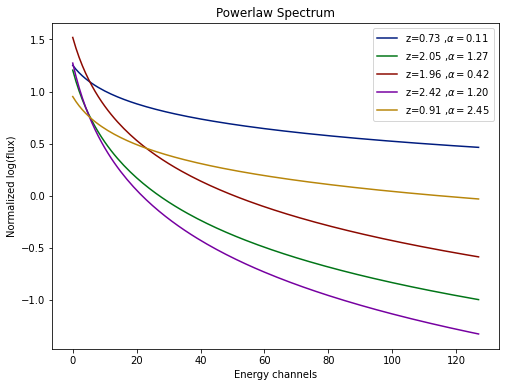

In [67]:
fig = plt.figure(figsize=(8,6))
for i in range(5):
    plt.plot(data_log_norm[i])
plt.xlabel('Energy channels')
plt.ylabel('Normalized log(flux)')
plt.title('Powerlaw Spectrum')
legends = [r'z={:.2f} ,$\alpha = ${:.2f}'.format(p[0],p[1]) for p in params[0:5]]
plt.legend(legends)
plt.show()

# Regression Neural Network

In [13]:
import numpy as np 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

print(tf.__version__)

2.3.1


In [58]:
def pred_model(l_struct):
  '''
  Prediction Model
  Returns A fully-connencted Model for 
  Network structure given by number of 
  layers in the input argument.
  Argument l_struct basically encodes the 
  information about layer structure.
  '''
  inp = keras.Input(shape=(128 , ))
  x = layers.Dense(l_struct[0] , activation='relu')(inp)
  l_struct = l_struct[1:]
  for l in l_struct:
    x = layers.Dense(l, activation='relu')(x)
  op = layers.Dense(2, activation='relu')(x)
  model = keras.Model(inputs=inp , outputs=op , name = 'regressor')
  return model

In [53]:
model = pred_model([64,64])
model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
model.summary()

Model: "regressor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 128)]             0         
_________________________________________________________________
dense_62 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_63 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_64 (Dense)             (None, 2)                 130       
Total params: 12,546
Trainable params: 12,546
Non-trainable params: 0
_________________________________________________________________


In [54]:
history = model.fit(data_log_norm, params,validation_split=0.2, epochs=100 )

Epoch 1/100
250/250 [==============================] - 0s 1ms/step - loss: 0.3386 - val_loss: 0.2859
Epoch 2/100
250/250 [==============================] - 0s 1ms/step - loss: 0.2455 - val_loss: 0.1917
Epoch 3/100
250/250 [==============================] - 0s 979us/step - loss: 0.1417 - val_loss: 0.0900
Epoch 4/100
250/250 [==============================] - 0s 1ms/step - loss: 0.0912 - val_loss: 0.0694
Epoch 5/100
250/250 [==============================] - 0s 956us/step - loss: 0.0741 - val_loss: 0.0602
Epoch 6/100
250/250 [==============================] - 0s 963us/step - loss: 0.0557 - val_loss: 0.0534
Epoch 7/100
250/250 [==============================] - 0s 960us/step - loss: 0.0463 - val_loss: 0.0496
Epoch 8/100
250/250 [==============================] - 0s 1ms/step - loss: 0.0453 - val_loss: 0.0430
Epoch 9/100
250/250 [==============================] - 0s 978us/step - loss: 0.0426 - val_loss: 0.0460
Epoch 10/100
250/250 [==============================] - 0s 980us/step - loss: 0.0

In [55]:
print(model.predict(data_log_norm[10:15]))
print(params[10:15])

[[1.6060946 1.3974855]
 [1.9500031 1.2034001]
 [2.2922244 1.1639719]
 [0.9209734 1.687948 ]
 [2.475227  2.4431455]]
[[1.60406411 1.3866544 ]
 [1.94903345 1.17356661]
 [2.28976839 1.13570447]
 [0.92091045 1.71251359]
 [2.47751834 2.35031311]]


In [56]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='train loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  #plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)


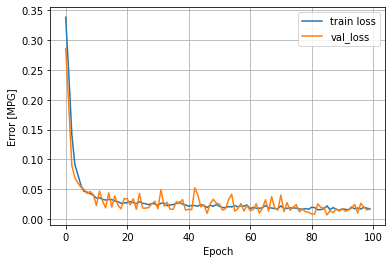

In [57]:
plot_loss(history)

In [77]:
model.save('fc_model')

INFO:tensorflow:Assets written to: fc_model/assets


## HyperParameter Tuning

In [70]:
from sklearn.metrics import mean_squared_error

In [94]:
def train_test_split(data, params , split):
    split = 1-split
    n_split = int(len(data)*split)
    d_list = [[d,p] for d,p in zip(data, params)]
    d_list = np.asarray(d_list)
    np.random.shuffle(d_list)
    d_list_train = d_list[:n_split,:]
    d_list_test = d_list[n_split:,:]

    train_data = d_list_train[:,0]
    train_data = np.asarray([t for t in train_data])
    test_data = d_list_test[:,0]
    test_data = np.asarray([t for t in test_data])
    
    train_p = d_list_train[:,1]
    train_p = np.asarray([t for t in train_p])

    test_p = d_list_test[:,1]
    test_p = np.asarray([t for t in test_p])

    return (train_data , train_p) , (test_data , test_p)

In [102]:
def model_tuning(model , data , params , plot=False , epochs = 20):
    (train_data, train_p) ,( test_d , test_p) = train_test_split(data , params , 0.2)
    history = model.fit(train_data, train_p,validation_split=0.2, epochs=epochs , verbose=0)
    y_true = np.copy(test_p)
    y_pred = model.predict(test_d)
    mse = mean_squared_error(y_true, y_pred)
    model.summary()
    return mse 

model = pred_model([64,64])
model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
#model.compile()
print(model_tuning(model , data_log_norm , params))

Model: "regressor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        [(None, 128)]             0         
_________________________________________________________________
dense_71 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_72 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_73 (Dense)             (None, 2)                 130       
Total params: 12,546
Trainable params: 12,546
Non-trainable params: 0
_________________________________________________________________
0.0013046410246752417
